In [2]:
import os
from radar_scenes.sequence import Sequence

# Load RadarScenes dataset.
PATH_TO_DATASET = "/home/robesafe/Datasets/RadarScenes"
if not os.path.exists(PATH_TO_DATASET):
    raise FileNotFoundError("Dataset not found at {}".format(PATH_TO_DATASET))

In [3]:
SEQUENCE_NUMBER = 1
filename = os.path.join(PATH_TO_DATASET, "data", f"sequence_{SEQUENCE_NUMBER}", "scenes.json")
sequence = Sequence.from_json(filename)
SCENES_NUMBER = sum(1 for x in sequence.scenes())  # a dirty way to compute the length of a generator.


In [4]:
# --- GROUP THE SEQUENCES BY 500 MS TIME INTERVAL
timestamps = sequence.timestamps
# print(timestamps)
timestamps_mod = [x - timestamps[0] < 500000 for x in timestamps]
# print(timestamps_mod)

timestamp_in_frame = []
frames = []
pivot = timestamps[0]

for idx, timestamp in enumerate(timestamps):
    if timestamp - pivot > 500000:
        pivot = timestamp
        frames.append(timestamp_in_frame)
        timestamp_in_frame = []
    else:
        timestamp_in_frame.append(timestamp)
    if idx == len(timestamps) - 1:
        frames.append(timestamp_in_frame)

print(len(frames))
# print(frames)

# chunk = [timestamp for timestamp in timestamps if timestamp - timestamps[0] < 500000]
# print(chunk)

169


First odom: (156869851616, -244.04, -267.69, -2.7298694, 12.35, -0.0280998)
First x: 5.5500030517578125, y: 2.3699951171875
(156870341624, -249.59, -270.06, -2.7429595, 12.27, -0.03228859)


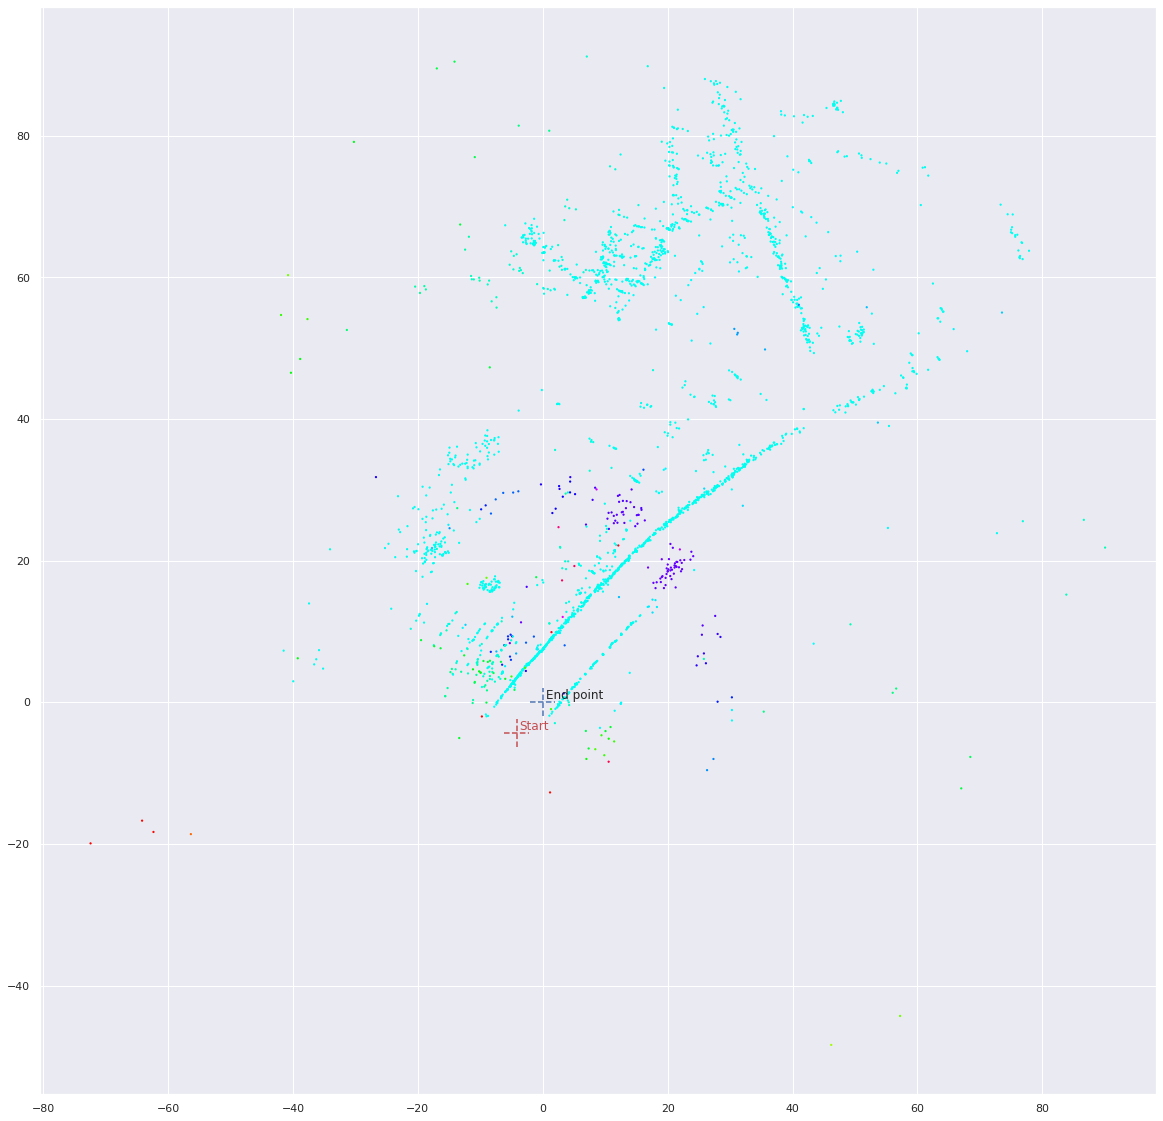

/home/robesafe/Datasets/RadarScenes/data/sequence_1/camera/156870446289.jpg


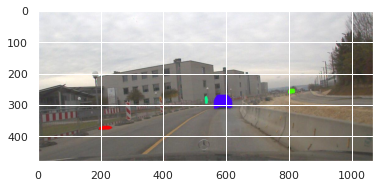

In [5]:
# --- COMBINE POINT CLOUDS IN A FRAME AND CREATE A GRID MAP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_theme()

frame = frames[14]
x_array, y_array, c_array = [], [], []
last_scene = sequence.get_scene(frame[-1])
odom = last_scene.odometry_data
camera_image_name = last_scene.camera_image_name
for timestamp in frame:
    scene = sequence.get_scene(timestamp)
    radar_data = pd.DataFrame(scene.radar_data)
    x_array.extend(radar_data["x_seq"].values.tolist())
    y_array.extend(radar_data["y_seq"].values.tolist())
    c_array.extend(radar_data["vr_compensated"].values.tolist())


first_scene = sequence.get_scene(frame[0])
first_odom = first_scene.odometry_data
first_x = first_odom[1] - odom[1]
first_y = first_odom[2] - odom[2]
print(f"First odom: {first_odom}")
print(f"First x: {first_x}, y: {first_y}")

# Translate to car origin
x_array = [x - odom[1] for x in x_array]
y_array = [y - odom[2] for y in y_array]

x_prime, y_prime = [], []

# Rotate yaw_seq at car origin
for (x, y) in zip(x_array, y_array):
    x_prime.append(x*np.cos(odom[3]) - y*np.sin(odom[3]))
    y_prime.append(x*np.sin(odom[3]) + y*np.cos(odom[3]))

first_x_prime = first_x*np.cos(odom[3]) - first_y*np.sin(odom[3])
first_y_prime = first_x*np.sin(odom[3]) + first_y*np.cos(odom[3])


print(odom)
# print(len(x))
# print(radar_data)
plt.figure(figsize=(20, 20))
plt.scatter(x_prime, y_prime, c=c_array, s=1.5, cmap='hsv')

# Start point
plt.vlines(first_x_prime, first_y_prime -2, first_y_prime + 2, linestyles='dashed', colors='r')
plt.hlines(first_y_prime, first_x_prime -2, first_x_prime + 2, linestyles='dashed', colors='r')
plt.text(first_x_prime + 0.5, first_y_prime + 0.5, "Start", color='r')

# End point
plt.vlines(0, -2, 2, linestyles='dashed')
plt.hlines(0, -2, 2, linestyles='dashed')
plt.text(0 + 0.5, 0 + 0.5, "End point")

plt.vlines

plt.show()

# Print image
img = mpimg.imread(camera_image_name)
print(camera_image_name)
imgplot = plt.imshow(img)


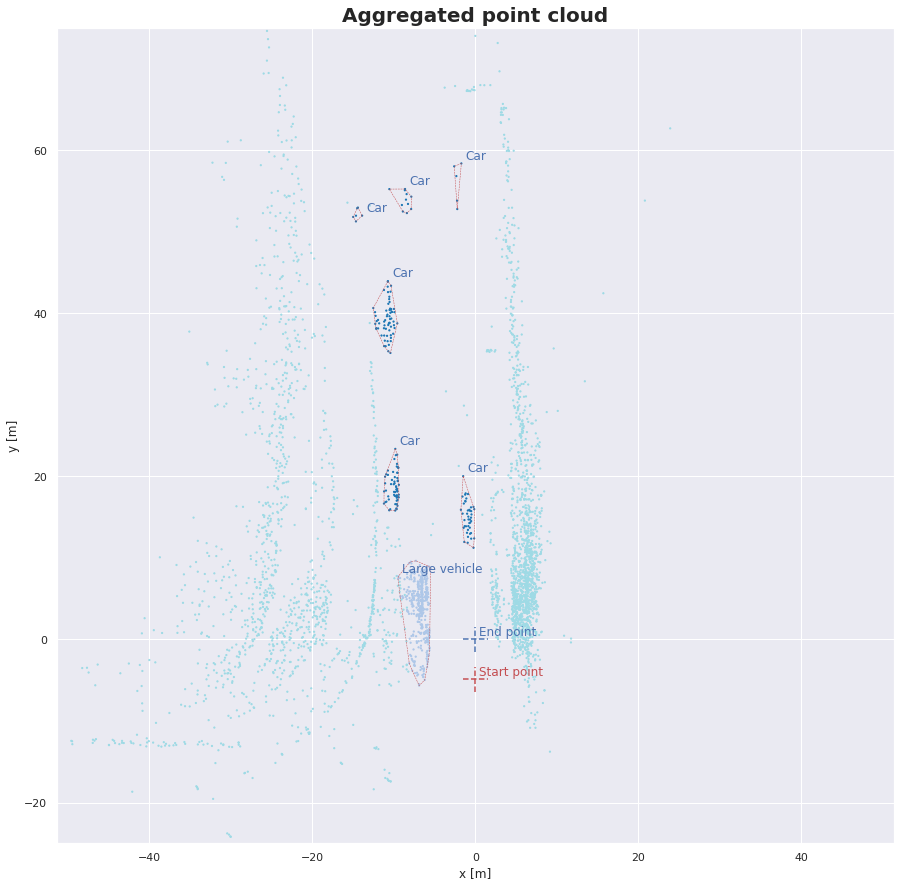

In [7]:
from preprocessing import aggregated_point_cloud, aggregated_camera_image, group_timestamps_by_time, plot_aggregated_point_cloud
test_grouped_timestamps = group_timestamps_by_time(timestamps, 500)
# assert test_grouped_timestamps == frames

test_frame = frames[166]
test_image_name = aggregated_camera_image(test_frame, sequence)
test_aggregated_point_cloud = aggregated_point_cloud(test_frame, sequence)
pc = test_aggregated_point_cloud[0]
x0 = test_aggregated_point_cloud[2]
y0 = test_aggregated_point_cloud[3]
x1 = test_aggregated_point_cloud[4]
y1 = test_aggregated_point_cloud[5]

plot_aggregated_point_cloud(pc, x0, y0, x1, y1)
# test_aggregated_point_cloud


In [9]:
from preprocessing import translate_categories
cat_num = pc['label_id'].unique().tolist()
track_ids = pc['track_id'].unique().tolist()
objects = [obj for obj in track_ids if len(obj) > 3]
print(cat_num, objects)

pc_mod = translate_categories(pc)
cat_vb = pc_mod['category'].unique().tolist()
print(cat_vb)
pc_mod.head()

[0, 1, 11] [b'9011a354b30211e68b40485b3918780b', b'f4600a8ac38811e682e014dae9339585', b'f4eb9d92c38e11e682e014dae9339585', b'eea4c198c38e11e682e014dae9339585', b'90e047aeb30211e68b40485b3918780b', b'8c17b5ecc39011e682e014dae9339585', b'9118eaa0b30211e68b40485b3918780b']
[0.0, 1.0, 5.0]


,timestamp,sensor_id,range_sc,azimuth_sc,rcs,vr,vr_compensated,x_cc,y_cc,x_seq,...,uuid,track_id,label_id,x_tr,y_tr,x_aggr,y_aggr,x_mod,y_mod,category
0,156948154036,2,12.304661,0.529772,6.424907,0.626424,10.736176,16.110817,0.449863,-734.915588,...,b'393cb76cea4b8d71f399bc7816c51717',b'9011a354b30211e68b40485b3918780b',0,2.264404,-11.020233,-10.375851,-4.349114,-0.221535,11.248288,0.0
1,156948154036,2,13.439933,0.544347,-5.775620,0.608229,10.708087,17.221394,0.750842,-734.432312,...,b'1a67540fd0ae81f9c89a8d57fc098b3b',b'9011a354b30211e68b40485b3918780b',0,2.747681,-12.064453,-11.307141,-5.024873,-0.506755,12.363008,0.0
2,156948154036,2,11.295632,1.124136,7.314980,-10.307603,-2.270505,12.586432,6.472218,-729.570984,...,b'f5f819a3747a1ba923df28013a58629d',b'f4600a8ac38811e682e014dae9339585',1,7.609009,-6.534119,-4.942412,-8.727215,-6.293156,7.809474,1.0
3,156948154036,2,11.906875,1.025466,12.076019,-11.128575,-2.523486,13.758672,5.917399,-729.920959,...,b'6ebca4f8b534275cccd71f3524107454',b'f4600a8ac38811e682e014dae9339585',1,7.259033,-7.782928,-6.235291,-8.624887,-5.721808,8.973764,1.0
4,156948154036,2,12.011667,1.103165,9.226326,-10.828605,-2.664048,13.297492,6.730606,-729.196838,...,b'c579220d9eff8dde6be95bb7f9b08a2e',b'f4600a8ac38811e682e014dae9339585',1,7.983154,-7.191650,-5.515353,-9.221251,-6.541423,8.524105,1.0


In [19]:
# from scipy.spatial import ConvexHull

# for obj in objects:
#     pc_obj1 = pc_mod[pc_mod['track_id'] == obj]
#     x_obj1 = pc_obj1['x_mod'].values

#     y_obj1 = pc_obj1['y_mod'].values
#     ch_obj1 = ConvexHull(list(zip(x_obj1, y_obj1)))

#     polygon = np.append(ch_obj1.vertices, ch_obj1.vertices[0])
#     plt.plot(x_obj1[polygon], y_obj1[polygon], 'r--', lw=2)
#     plt.text(x_obj1[polygon[0]], y_obj1[polygon[0]], obj, color='r')

# plot_aggregated_point_cloud(pc_mod, x0, y0, x1, y1)

0.16


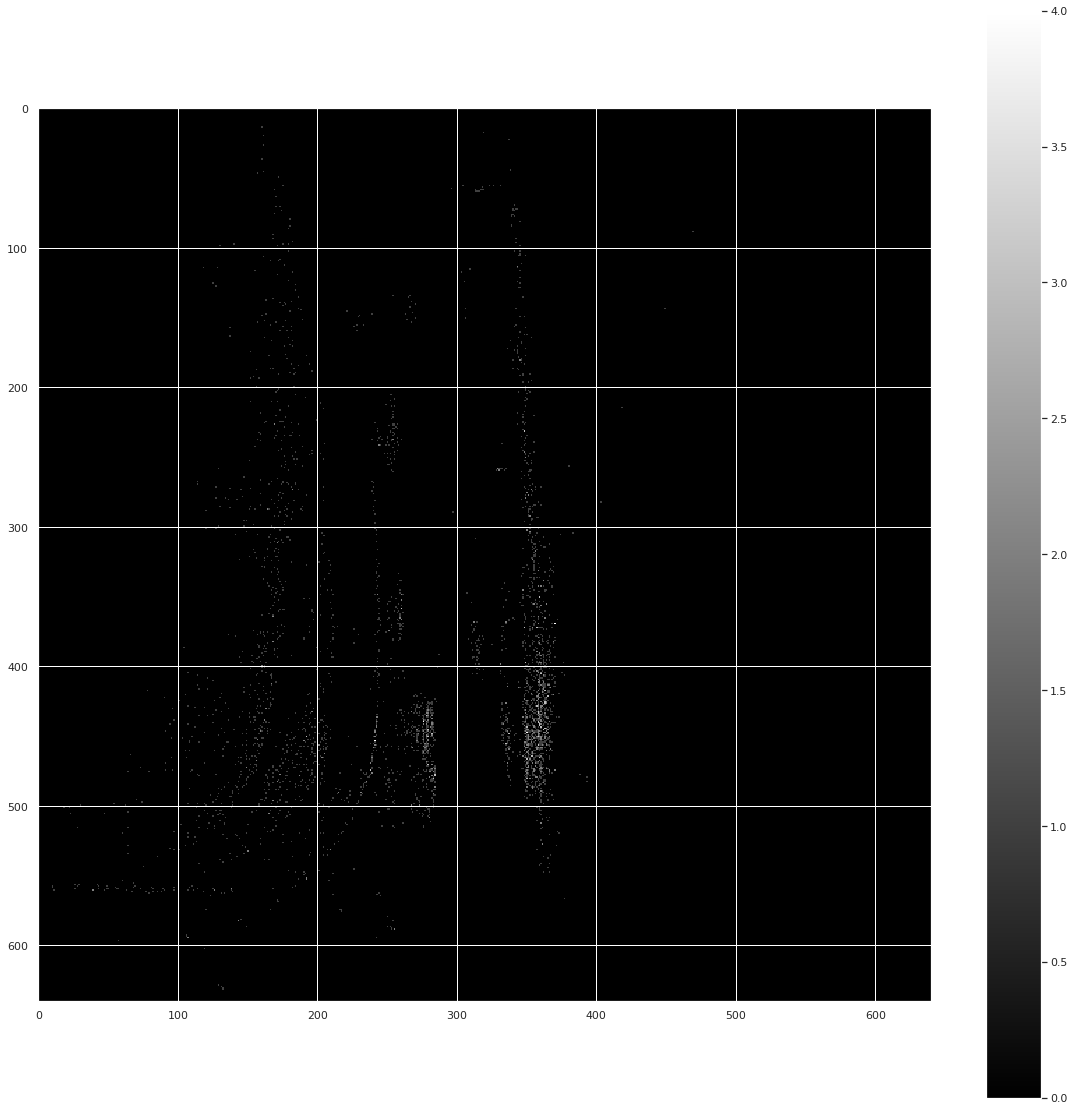

In [10]:
# --- CREATE A GRID MAP FROM AGGREGATED POINT
N_CELLS = 640
CELL_SIZE = 0.16
print(CELL_SIZE)

# Create an empty grid
grid = np.zeros((N_CELLS, N_CELLS))

# Add every point to the grid
for row in pc_mod.itertuples():
    if -50 <= row.x_mod <= 50 and -25 <= row.y_mod <= 75:
        x = ((row.x_mod / CELL_SIZE) + N_CELLS / 2)
        y = 640 - ((row.y_mod / CELL_SIZE) + N_CELLS / 4)
        if 0 <= x < N_CELLS and 0 <= y < N_CELLS:
            grid[int(y), int(x)] += 1
        

# Plot the grid
plt.figure(figsize=(20, 20))
plt.imshow(grid, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.16


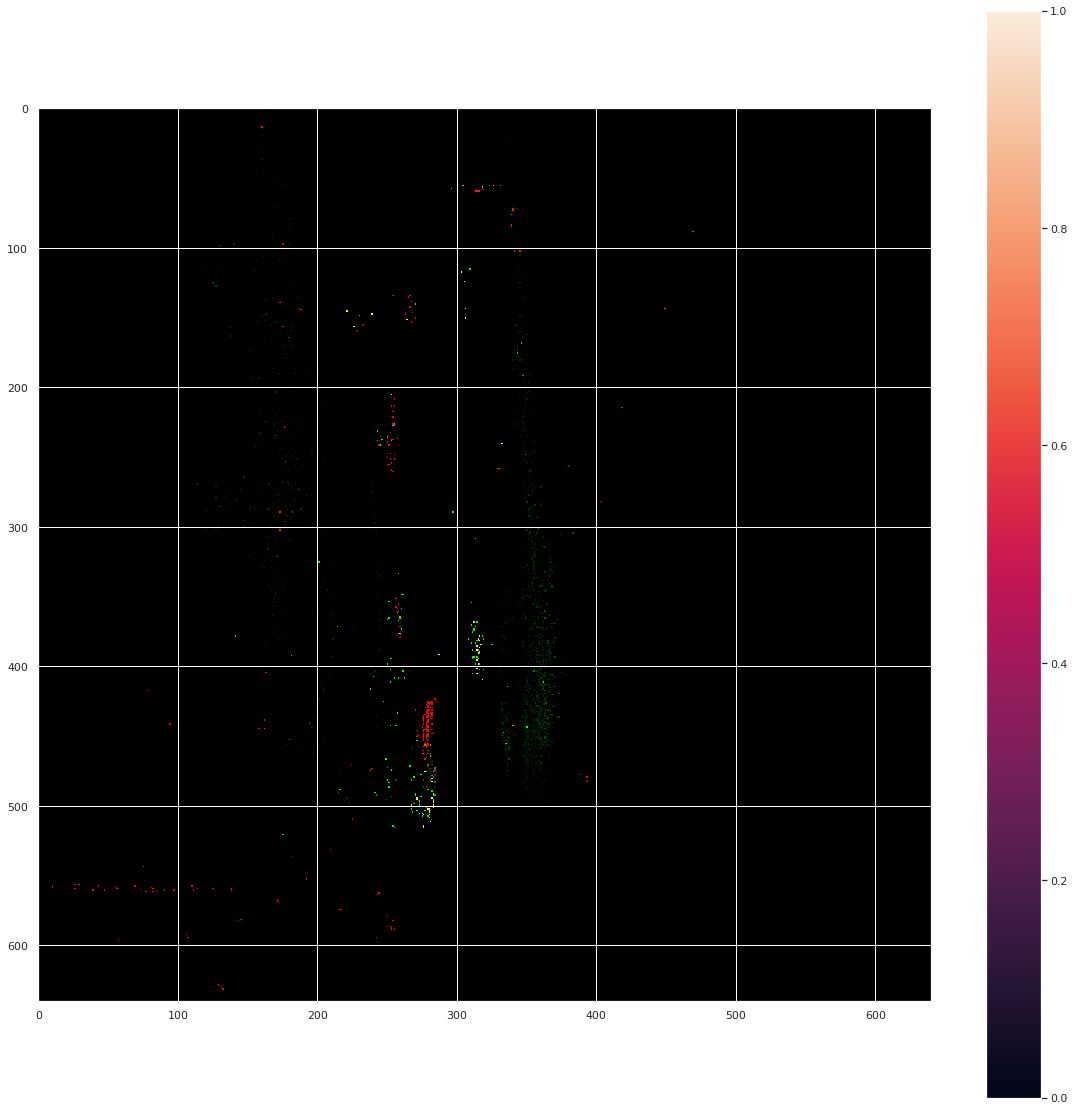

In [11]:
# --- CREATE A GRID MAP FROM AGGREGATED POINT
N_CELLS = 640
CELL_SIZE = 0.16
print(CELL_SIZE)

# Create an empty grid
grid = np.zeros((4, N_CELLS, N_CELLS))

# Add every point to the grid
for row in pc_mod.itertuples():
    if -50 <= row.x_mod <= 50 and -25 <= row.y_mod <= 75:
        x = ((row.x_mod / CELL_SIZE) + N_CELLS / 2)
        y = 640 - ((row.y_mod / CELL_SIZE) + N_CELLS / 4)
        if 0 <= x < N_CELLS and 0 <= y < N_CELLS:
            grid[0, int(y), int(x)] = max(grid[0, int(y), int(x)], row.rcs)
            grid[1, int(y), int(x)] = max(grid[1, int(y), int(x)], row.vr_compensated)
            grid[2, int(y), int(x)] = min(grid[2, int(y), int(x)], row.vr_compensated)
            grid[3, int(y), int(x)] += 1
        

# Change grid from N x W x H to W x H x N
grid = np.transpose(grid, (1, 2, 0))

# Plot the grid
plt.figure(figsize=(20, 20))
plt.imshow(grid[:,:,0:3], interpolation='nearest')
plt.colorbar()
plt.show()

In [44]:
from radar_scenes.sequence import get_training_sequences, get_validation_sequences

training_sequences = get_training_sequences(os.path.join(PATH_TO_DATASET, "data", "sequences.json"))
print(training_sequences)
validation_sequences = get_validation_sequences(os.path.join(PATH_TO_DATASET, "data", "sequences.json"))
print(validation_sequences)
print(len(training_sequences) + len(validation_sequences))

['sequence_1', 'sequence_2', 'sequence_3', 'sequence_4', 'sequence_7', 'sequence_8', 'sequence_9', 'sequence_10', 'sequence_11', 'sequence_12', 'sequence_13', 'sequence_15', 'sequence_16', 'sequence_17', 'sequence_18', 'sequence_20', 'sequence_21', 'sequence_22', 'sequence_23', 'sequence_25', 'sequence_26', 'sequence_27', 'sequence_28', 'sequence_29', 'sequence_30', 'sequence_32', 'sequence_33', 'sequence_34', 'sequence_35', 'sequence_36', 'sequence_37', 'sequence_38', 'sequence_39', 'sequence_40', 'sequence_41', 'sequence_43', 'sequence_44', 'sequence_45', 'sequence_46', 'sequence_47', 'sequence_49', 'sequence_50', 'sequence_51', 'sequence_52', 'sequence_54', 'sequence_55', 'sequence_56', 'sequence_57', 'sequence_59', 'sequence_60', 'sequence_61', 'sequence_62', 'sequence_64', 'sequence_65', 'sequence_66', 'sequence_67', 'sequence_69', 'sequence_70', 'sequence_71', 'sequence_72', 'sequence_74', 'sequence_75', 'sequence_76', 'sequence_77', 'sequence_78', 'sequence_80', 'sequence_81', '

In [12]:
import plotly.graph_objects as go

trace1 = go.Scatter(
    x=pc_mod['x_mod'],
    y=pc_mod['y_mod'],
    mode='markers',
    marker=dict(color='rgb(255, 128, 2)', size=1),
    text=pc_mod['label_id'],
)
data = [trace1]
fig = go.Figure(data=data)
fig.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


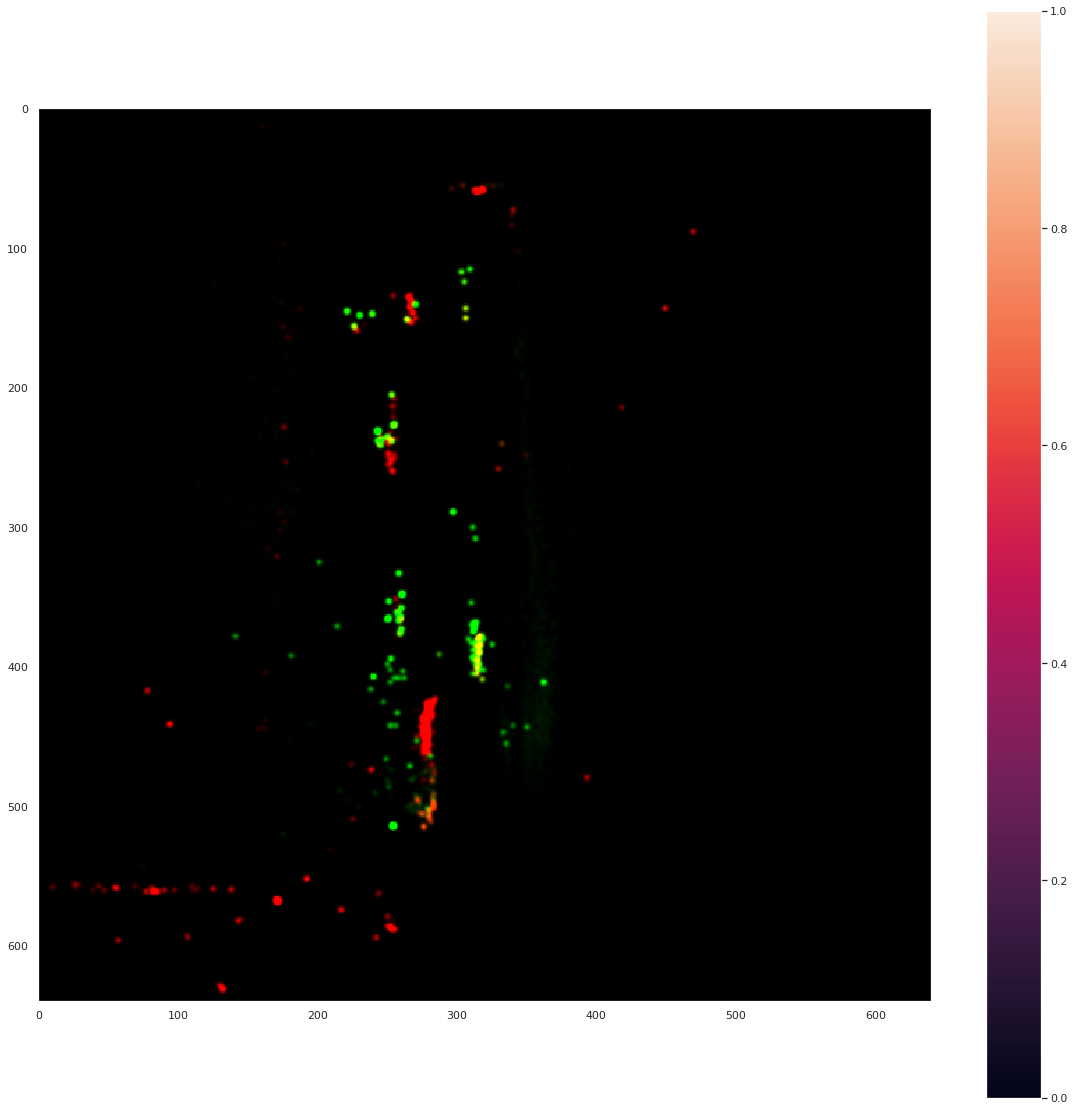

Saved /home/robesafe/Datasets/RadarScenes_BEV/test2.png


In [27]:
# --- CREATE DATASET
import cv2 as cv
from scipy import ndimage

KERNEL_SIZE = (7, 7)
img_wo_blur = grid[:,:,0:3]
img_blur = cv.GaussianBlur(img_wo_blur, KERNEL_SIZE, 0)


plt.figure(figsize=(20, 20))
plt.imshow(img_blur, interpolation='nearest')
plt.colorbar()
plt.grid()
plt.show()

# Set the path to the new dataset.
PATH_TO_NEW_DATASET = "/home/robesafe/Datasets/RadarScenes_BEV"
if not os.path.exists(PATH_TO_NEW_DATASET):
    os.makedirs(PATH_TO_NEW_DATASET)

# Multiply channels by 255 to get them in the range [0, 255].
img_blur = img_blur * 255

# Rotate the image 30 degrees clockwise.
img_blur = ndimage.rotate(img_blur, 30)


# Save the image
data_filename = os.path.join(
    PATH_TO_NEW_DATASET,
    f"test2.png"
)
cv.imwrite(data_filename, img_blur)
print(f"Saved {data_filename}")